Select kernel `segment-anything`

Run this cell to import necessary packages and initialise SAM model and mask generator

In [13]:
# Import the necessary libraries
import numpy as np 
import torch
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import cv2
from ultralytics import YOLO
from PIL import Image
import os
import shutil
from sklearn.model_selection import train_test_split
from IPython.display import display
from IPython.display import clear_output
import yaml
from ultralytics import YOLO
import glob
import pickle

sam_checkpoint = "sam_vit_h_4b8939.pth" # Path to the checkpoint file
model_type = "vit_h" # Model type

device = "cuda" if torch.cuda.is_available() else "cpu" # Use GPU if available, otherwise use CPU

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint) # Load the model
sam.to(device=device) # Move the model to the device

mask_generator = SamAutomaticMaskGenerator(sam) # Create a mask generator
mask_predictor = SamPredictor(sam) # Create a mask predictor

In [14]:
from jupyter_bbox_widget import BBoxWidget
import ipywidgets as widgets
import os
import json
import base64

In [2]:
# used to display the segment, without the background
def display_mask_img(mask_img, h, w):
    display(mask_img.resize((w,h)))


# used to load the images using cv2 from specidic path
def load_images(path):
    images = [] # stores the images and their filenames
    for filename in os.listdir(path): # iterate through the files in the directory
        if filename.endswith(".jpg") or filename.endswith(".png"): # check if the file is an image
            img_path = os.path.join(path, filename) # get the path of the image
            
            image = cv2.imread(img_path) # read the image using cv2
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB

            images.append([image, filename]) # add the image and its filename to the list
    
    return images


# extract the coordinates of the segment from SAM and store them in a list
def extract_segment(mask):
    binary_mask = np.array(mask) # get the segmentation of the mask and convert it to a numpy array
    binary_mask = (binary_mask * 255).astype(np.uint8) # convert the mask to a binary mask

    contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # find contours from the binary image
    polygon_coords = [] # stores the coordinates of the vertices of the polygon
    
    for contour in contours:
        epsilon = 0.01 * cv2.arcLength(contour, True) # approximate contour with accuracy proportional to the contour perimeter
        approx = cv2.approxPolyDP(contour, epsilon, True) # approximate contour with the Douglas-Peucker algorithm

        polygon_coords.append(approx) # add the coordinates of the vertices of the polygon to the list
    return polygon_coords


# TODO: Refine further
# define a function to filter the list of mask based on the area
def filter_mask(mask, h, w):
    # specify the minimum area of the mask
    min_area = 0 * h * w # In progress: leave as 0 for now to include every segment
    # create a new dictionary
    new_dict = []
    
    # filter the masks based on the area
    for i in mask:
        if i['area'] > min_area:
            new_dict.append(i)
    # sort the masks based on the area in descending order
    new_dict = sorted(new_dict, key=lambda k: k['area'], reverse=False)
    
    return new_dict


# takes the polygon coordinates of the current segment and draws it on the original image
def draw_segment(img, coord):
    cv2.drawContours(img, coord, -1, (0, 255, 0), 1) # draw the contours on the image
    plt.figure(figsize=(10,10)) # set the size of the figure 
    plt.imshow(img, cmap='gray') # show the image
    plt.axis('off') # turn off the axis
    plt.show() # show the image


# converts the list of numpy array to a list a list for easier manipulation
def numpy_to_list(numpy_arr):
    coord_list = [coord[0].tolist() for array in numpy_arr for coord in array] # Convert each numpy array in the list to a regular list and extract the inner lists into coord_list
    flat_list = [] # stores the flattened list of coordinates
    for coord in coord_list: # convert the list of lists into a flat list
        flat_list.append(coord[0]) # append the x coordinate
        flat_list.append(coord[1]) # append the y coordinate
    return flat_list


# this function draws the existing segments on the image
def draw_existing_segments(image, filename):
    # get the path of the txt file
    train_txt_path = os.path.join('dataset/train/labels', filename[0:-4] + '.txt')
    valid_txt_path = os.path.join('dataset/valid/labels', filename[0:-4] + '.txt')
    
    # check if the txt file exists
    if os.path.exists(train_txt_path):
        # open the txt file
        with open(train_txt_path, 'r') as f:
            lines = f.readlines()
        # iterate over the lines in the txt file
        for line in lines:
            parts = line.strip().split() # split the line into parts
            polygon = [float(x) for x in parts[5:]] # get the polygon coordinates

            # draw the segment on the image
            draw_segmentation(image, polygon)
    elif os.path.exists(valid_txt_path):
        # open the txt file
        with open(valid_txt_path, 'r') as f:
            lines = f.readlines()
        # iterate over the lines in the txt file
        for line in lines:
            parts = line.strip().split()
            polygon = [float(x) for x in parts[5:]] # get the polygon coordinates

            # draw the segment on the image
            draw_segmentation(image, polygon)


# gets all the relevant data for YOLO from the image and the mask by using the functions defined above
def get_yolo_data(image, masks, h, w, labels, filename):
    legend = "" 

    for key, val in labels.items(): 
        legend += str(key) + ": " + val +'\n' # turn labels dictionary into a string
    masks = filter_mask(masks, h, w) # filter the masks based on the area

    data = [] # stores the data for YOLO
    k = 0 # used to keep track of the number of segments currently not discarded
    image_1 = image.copy() # create a copy of the image to draw the segment on
    draw_existing_segments(image_1, filename) # draw the existing segments on the image
    
    for i in range(len(masks)): # iterate through the masks
        image_copy = image_1.copy() # create a copy of the image to draw the segment on

        bound_box = masks[i]['bbox'] # get the bounding box xywh coordinates of the mask
        current_mask = masks[i]['segmentation'] # get the segmentation of the mask

        current_mask_img = image * current_mask[:,:,np.newaxis] + (1 - current_mask[:,:,np.newaxis]) * 255 # get the mask image
        current_mask_img = np.uint8(current_mask_img)  # convert the mask image to uint8
        current_mask_img = Image.fromarray(current_mask_img) # convert the mask image to a PIL image

        segment_coords = extract_segment(current_mask) # extract the numpy coordinates of the segment from the mask
        flat_segment_coords = numpy_to_list(segment_coords) # convert the numpy coordinates to a flat list

        for j in range(len(flat_segment_coords)): # normalise the coordinates of the segment
            if j%2 == 0:
                flat_segment_coords[j] = flat_segment_coords[j]/w
            else:
                flat_segment_coords[j] = flat_segment_coords[j]/h

        for l in range(4): # normalise the bounding box coordinates
            if l%2 == 0:
                bound_box[l] = bound_box[l]/w
            else:
                bound_box[l] = bound_box[l]/h

        draw_segment(image_copy, segment_coords) # draw the segment on the image and display it

        while True:
            try: # prompt the user to enter a number and display the legend (key: label) for reference
                label = int(input(legend + "Please enter a number: "))
                if 0 <= label < len(labels):
                    break
                else:
                    print("The number is not within the range. Please try again.")
            except ValueError: 
                print("That's not a valid number. Please try again.")

        clear_output(wait=True)
        if (labels[label] == "Next segment"): # if the label is 'Next segment', discard the segment
            continue 
        if (labels[label] == "Next frame"): # if the label is Next image, go to the next image
            break
                
        data.append([]) # add a new list to the data list
        flat_segment_coords[:0] = bound_box # add the bounding box coordinates to the beginning of the list
        flat_segment_coords.insert(0, label) # add the class label at the beginning of the list
        data[k].append(flat_segment_coords) # add flat coordinates of the segment to the list
        data[k].append(segment_coords) #add the numpy coordinates of the segment to the list
        cv2.drawContours(image_1, segment_coords, -1, (0, 0, 255), 1) # draw the contours on the image
        k += 1 

    return data


# this is used to split the images into training and validation sets into the dataset folder
def split_data(src_directory, out_directory, test_size=0.2):
    os.makedirs(out_directory, exist_ok=True) # create the dataset directory

    os.makedirs(os.path.join(out_directory, 'train', 'images'), exist_ok=False) # create the train images directory
    os.makedirs(os.path.join(out_directory, 'valid', 'images'), exist_ok=False) # create the valid images directory
    os.makedirs(os.path.join(out_directory, 'train', 'labels'), exist_ok=False) # create the train labels directory
    os.makedirs(os.path.join(out_directory, 'valid', 'labels'), exist_ok=False) # create the valid labels directory

    all_files = os.listdir(src_directory) # get all the files in the source directory
    train_files, valid_files = train_test_split(all_files, test_size=test_size, random_state=42) # split the files into training and validation sets

    # Move files into the train and valid directories
    for file_name in train_files:
        shutil.copy(os.path.join(src_directory, file_name), os.path.join(out_directory, 'train', 'images', file_name))
    for file_name in valid_files:
        shutil.copy(os.path.join(src_directory, file_name), os.path.join(out_directory, 'valid', 'images', file_name))


# this is used to create the data.yaml (necessary for YOLO training) file in the dataset folder 
def create_yaml(labels, path, train_path="train/images", val_path="valid/images", output_path="dataset/data.yaml"):
    # copies labels with the last two elemens removed
    labels_copy = labels.copy()
    labels_copy.pop()
    labels_copy.pop()

    data = {
        'names': labels_copy,
        'path': path,
        'train': train_path,
        'val': val_path
    }

    with open(output_path, 'w') as outfile: # write the data to the yaml file
        yaml.dump(data, outfile, default_flow_style=False)


# this is used to extract the frames from a video file and output into specified directory as jpg images
def extract_frames(video_path, output_dir, frame_interval=300, max_dimension=800):
    filename = os.path.splitext(os.path.basename(video_path))[0]
    os.makedirs(output_dir, exist_ok=True)

    video = cv2.VideoCapture(video_path)

    if not video.isOpened():
        print(f"Could not open video file: {video_path}")
        return

    fps = video.get(cv2.CAP_PROP_FPS)

    if fps >= 50:
        frame_interval *= 2
    
    frame_index = 0

    while True:
        success, frame = video.read()
        if not success: 
            break

        # Resize the frame if necessary
        height, width = frame.shape[:2]
        if max(height, width) > max_dimension:
            scale = max_dimension / max(height, width)
            frame = cv2.resize(frame, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)

        if frame_index % frame_interval == 0:
            output_path = os.path.join(output_dir, f"{filename}_frame_{frame_index}.png")
            cv2.imwrite(output_path, frame)

        frame_index += 1

    video.release()


# function to process a batch of images
def process_batch(images, batches):
    
    for temp_image in images:
        h, w = temp_image[0].shape[:2]
        batches.append([temp_image[0], mask_generator.generate(temp_image[0]),h,w,temp_image[1]]) # Generate masks
    
    images.clear() # clear the images list
    torch.cuda.empty_cache() # empty the GPU cache


# this is used to load the images from the specified directory and output the data in the format required for YOLO training
def load_images_from_video(img_path, vid_path, frame_interval, ds_path="3-dataset", batch_size=4):
    for filename in os.listdir(vid_path):
        extract_frames(os.path.join(vid_path, filename), img_path, frame_interval)
    
    split_data(img_path, ds_path) # splits into train, valid sets and moves into ds_path folder

    train_add_images = load_images(ds_path + '/train/images/')
    valid_add_images = load_images(ds_path + '/valid/images/')

    train_add_batches = [] # initialise the add_batches list
    valid_add_batches = [] 

    temp_images = [] # initialise the temp_images list

    for image in train_add_images:
        temp_images.append(image)
        if len(temp_images) == batch_size:
            process_batch(temp_images, train_add_batches)
    if temp_images:
        process_batch(temp_images, train_add_batches)

    for image in valid_add_images:
        temp_images.append(image)
        if len(temp_images) == batch_size:
            process_batch(temp_images, valid_add_batches)
    if temp_images:
        process_batch(temp_images, valid_add_batches)

    return train_add_batches, valid_add_batches



# this is used to format the YOLO data into appropriate txt files for use in YOLO training
def output_to_txt(data, directory):
    fname = data[-1][0:-4]  # get the filename from the last element of the data, remove the .jpg extension
    os.makedirs(directory, exist_ok=True)  # creates the directory if it doesn't exist

    with open(os.path.join(directory, fname + '.txt'), 'w') as f:  # joins the directory with the filename
        for line in data[:-1][0]:  # iterate over all elements except for the last one which is the filename
            class_num = line[0][0]  # get the class number
            coords = line[0][5:]  # get the list of coordinates starting from the 6th element which is the first coordinate of the polygon segment
            f.write(f"{class_num} {' '.join(map(str, coords))}\n")  # write to the file


# cleans the dataset
def delete_empty_labels_and_images(label_dir, image_dir):
    # Get a list of all txt files in label directory
    label_files = glob.glob(os.path.join(label_dir, '*.txt'))
    
    for label_file in label_files:
        # Check if the file is empty
        if os.stat(label_file).st_size == 0:
            # If empty, delete the label file
            os.remove(label_file)
            
            # Construct the corresponding image file path
            image_file = os.path.join(image_dir, os.path.splitext(os.path.basename(label_file))[0] + '.png')
            
            # Delete the corresponding image file, if it exists
            if os.path.exists(image_file):
                os.remove(image_file)


# this is used to move the data from 3-dataset to dataset for use in YOLO training
def move_files(src_img, src_label, dest_img, dest_label):
    # Check if destination directories exist, if not, create them
    os.makedirs(dest_img, exist_ok=True)
    os.makedirs(dest_label, exist_ok=True)

    all_images = os.listdir(src_img)
    all_labels = os.listdir(src_label)
    
    for image in all_images:
        shutil.copy(os.path.join(src_img, image), os.path.join(dest_img, image))

    
    for label in all_labels:
        shutil.copy(os.path.join(src_label, label), os.path.join(dest_label, label))


# this is used to move the videos from 1-source to dataset/sources
def move_source_vid(src_vid, dest_vid):
    # Check if destination directories exist, if not, create them
    os.makedirs(dest_vid, exist_ok=True)

    all_videos = os.listdir(src_vid)
    
    for video in all_videos:
        shutil.copy(os.path.join(src_vid, video), os.path.join(dest_vid, video))


# clears directory
def clear_directory(directory):
    # Be careful with this function! It deletes all files and subdirectories in the specified directory
    shutil.rmtree(directory)
    os.mkdir(directory)


# this is used as the entry point for the program
def main_program(train_mask_list, valid_mask_list, labels, ds_path = "3-dataset"):
    train_data = []
    valid_data = []
    
    for mask in train_mask_list: # iterate over the train masks to get the data for each image in the train set
        train_data.append( [get_yolo_data(mask[0], mask[1], mask[2], mask[3], labels, mask[4]), mask[4]] )
        output_to_txt(train_data[-1], ds_path + '/train/labels/') # output the data to txt files
    for mask in valid_mask_list: # iterate over the valid masks to get the data for each image in the valid set
        valid_data.append( [get_yolo_data(mask[0], mask[1], mask[2], mask[3], labels, mask[4]), mask[4]] )
        output_to_txt(valid_data[-1], ds_path + '/valid/labels/') # output the data to txt files
        
        # data = [
        #          [
        #            [class, coords, numpy_coords]
        #            ...
        #            [class, coords, numpy_coords], 
        #            filename22
        #          ],  
        #          ...
        #        ]
        # 
        # ---> format of data
        
    # cleans the dataset
    delete_empty_labels_and_images(ds_path + '/train/labels', ds_path + '/train/images')
    delete_empty_labels_and_images(ds_path + '/valid/labels', ds_path + '/valid/images')


'''
for editing the .txt labels
'''


# this takes the polygon coordinates extracted from the yolo txt data and draws them on the corresponding image 
def draw_segmentation(image, segmentation, color=(0,0,255), thickness=2):
    # Rescale the segmentation points back to image dimensions
    points = np.array(segmentation).reshape(-1, 2) * [image.shape[1], image.shape[0]]
    points = points.astype(int)
    
    # Draw the polygon on the image
    cv2.polylines(image, [points], isClosed=True, color=color, thickness=thickness)


# this function reads the yolo txt file and retrieves the corresponding image and draws the segmentation on it, with the help of draw_segmentation()
def read_and_draw(file_path, img_folder_path, labels, ds_path):
    with open(file_path, 'r') as f: # open the txt file
        lines = f.readlines()
    
    i = 0 # initialize the counter

    while i < len(lines): # iterate over the lines in the txt file
        line = lines[i] # get the current line
        parts = line.strip().split() # split the line into parts
        polygon = [float(x) for x in parts[5:]] # get the polygon coordinates

        # Load the corresponding image
        image_name = os.path.splitext(os.path.basename(file_path))[0] + '.jpg'
        image_path = os.path.join(img_folder_path, image_name)
        image = cv2.imread(image_path)

        if image is None: # if the image is not found, delete the corresponding txt file
            image_name = os.path.splitext(os.path.basename(file_path))[0] + '.png'
            image_path = os.path.join(img_folder_path, image_name)
            image = cv2.imread(image_path)

        draw_segmentation(image, polygon) # draw the segmentation on the image

        plt.figure(figsize=(10, 10)) # set the figure size
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) # show the image
        plt.axis('off') # turn off the axis
        clear_output(wait=True)

        plt.show()
        
        legend = ''
        for key, val in labels.items(): # iterate over the labels
            legend += str(key) + ': ' + str(val) + '\n' # add the label to the legend

        # Prompt the user to modify the class label or delete the segment
        action = input("Enter 'd' to delete this segment, 'e' to edit class label, or any other key to move to next segment: ")
        if action.lower() == 'd':
            # Remove this line from the list
            lines.remove(line)
            i -= 1
        elif action.lower() == 'e':
            new_class = input(legend + "Enter new class label: ")
            # Replace the class label in this line
            lines[lines.index(line)] = new_class + line[1:]
        # Write back the modifications
        with open(file_path, 'w') as f:
            f.writelines(lines)
        i += 1
    
    # cleans the dataset
    delete_empty_labels_and_images(ds_path + '/train/labels', ds_path + '/train/images')
    delete_empty_labels_and_images(ds_path + '/valid/labels', ds_path + '/valid/images')


# this function performs segmentation on the images in the specified directory and returns the corresponding masks
def segment_images(img_path, ds_path, batch_size=4):
    images = load_images(img_path) # load the images from the specified directory

    batches = [] # initialise the batches list
    temp_images = [] # initialise the temp_images list

    for image in images:
        temp_images.append(image)
        if len(temp_images) == batch_size:
            process_batch(temp_images, batches)
    if temp_images:
        process_batch(temp_images, batches)

    return batches


# this function adds on to the existing txt files
def add_to_txt(data, directory):
    fname = data[-1][0:-4]  # get the filename from the last element of the data, remove the .png extension

    with open(os.path.join(directory, fname + '.txt'), 'w'):
        for line in data[:-1][0]:
            class_num = line[0][0]
            coords = line[0][5:]
            f.write(f"{class_num} {' '.join(map(str, coords))}\n") # write to the file


# this is used as entry point to reannotate the images with new labels
def reannotate(mask_list, labels, label_path):
    data = []

    for mask in mask_list: # iterate over the masks to get the data for each image
        data.append([get_yolo_data(mask[0], mask[1], mask[2], mask[3], labels, mask[4]), mask[4]]) # get the data for each image
        add_to_txt(data[-1], label_path) # write the data to txt files


# this is used as entry point to reannotate the images with new labels
def refine_annotation(mask_list, labels, label_path):
    data = []

    for mask in mask_list: # iterate over the masks to get the data for each image
        data.append([get_yolo_data(mask[0], mask[1], mask[2], mask[3], labels, mask[4]), mask[4]]) # get the data for each image
        add_to_txt(data[-1], label_path) # write the data to txt files

In [43]:
img_path = r"C:\Users\Adrian\Desktop\projects\sam-2-yolo\backup\06-07-23-model\dataset\train\images\2022-09-05_04-20-00_Cam119_T1_1_(Phase_0)_frame_12600.png"

In [44]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [45]:
widget = BBoxWidget(
    image = encode_image(img_path),
    classes=['plane', 'airtug']
)

widget


BBoxWidget(classes=['plane', 'airtug'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564…

In [50]:
widget.bboxes

[{'x': 667, 'y': 279, 'width': 128, 'height': 52, 'label': 'plane'},
 {'x': 625, 'y': 249, 'width': 45, 'height': 23, 'label': 'plane'},
 {'x': 531, 'y': 246, 'width': 66, 'height': 26, 'label': 'plane'},
 {'x': 443, 'y': 277, 'width': 34, 'height': 19, 'label': 'plane'},
 {'x': 78, 'y': 256, 'width': 101, 'height': 45, 'label': 'plane'}]

In [52]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box_list = []

for box in widget.bboxes:
    box = np.array([ # convert the box to a numpy array
        box['x'],
        box['y'],
        box['x'] + box['width'],
        box['y'] + box['height']
    ])
    box_list.append(box)

import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(img_path) # read the image
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB) # convert the image to RGB

mask_predictor.set_image(image_rgb) # set the image for the mask predictor
predict_list = [] # initialise the predict list

for box in box_list:
    masks, scores, logits = mask_predictor.predict(
        box=box,
        multimask_output=True
    )
    predict_list.append([masks, scores, logits, box]) # append the masks, scores, logits and box to the predict list

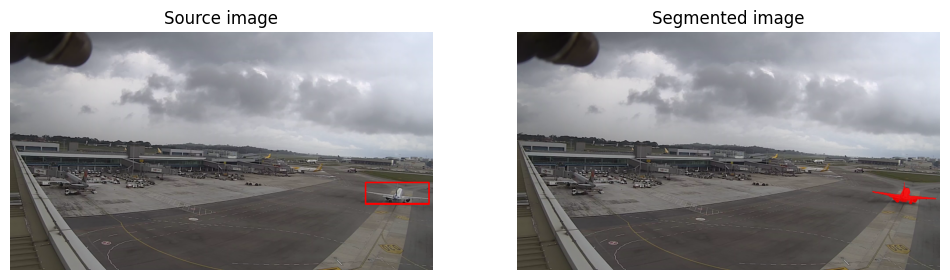

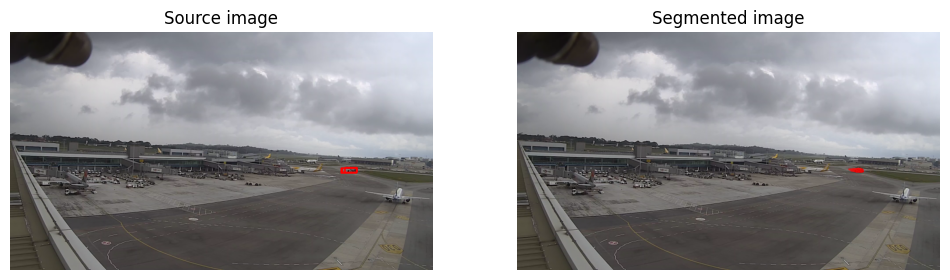

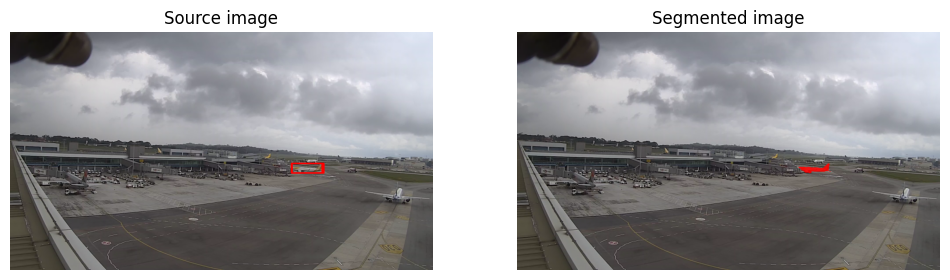

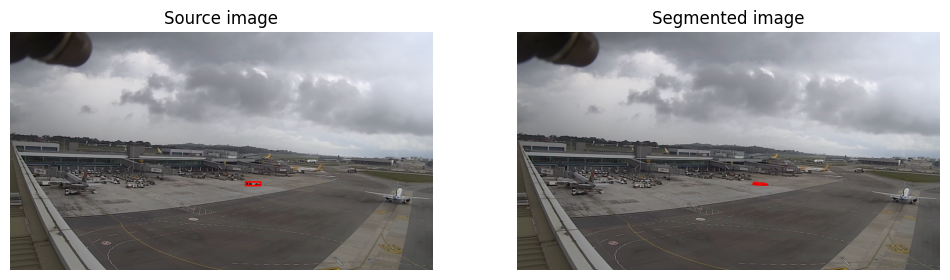

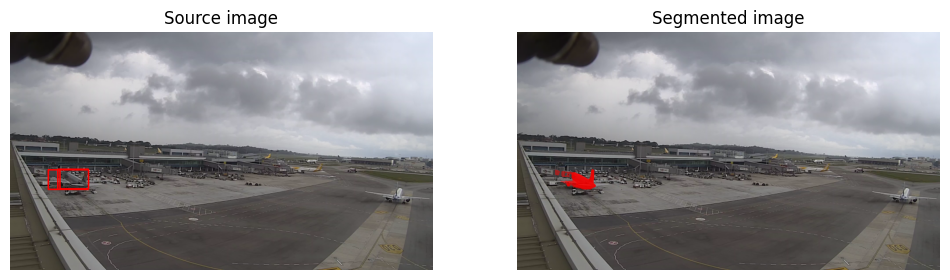

In [53]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red()) # initialise the box annotator
mask_annotator = sv.MaskAnnotator(color=sv.Color.red()) # initialise the mask annotator

detections_list = [] # initialise the detections list

for predictions in predict_list:
    detections = sv.Detections(
        xyxy = sv.mask_to_xyxy(masks=predictions[0]), # convert the masks to xyxy format
        mask = predictions[0]
    )

    detections_list.append(detections) # append the detections to the detections list

for detections in detections_list:
    source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True) # annotate the image with the boxes
    segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections) # annotate the image with the masks

    sv.plot_images_grid(
        images=[source_image, segmented_image],
        grid_size=(1, 2),
        titles=['Source image', 'Segmented image']
    )




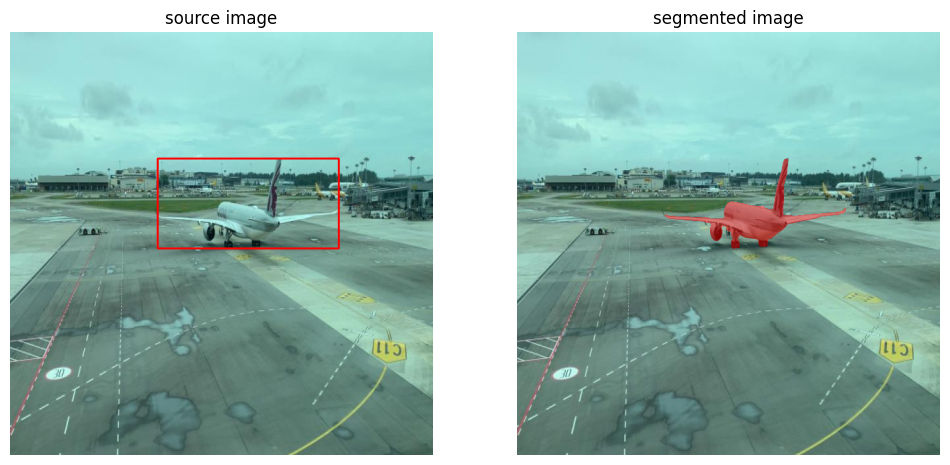

In [123]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red()) # initialise the box annotator
mask_annotator = sv.MaskAnnotator(color=sv.Color.red()) # initialise the mask annotator

detections = sv.Detections( # initialise the detections
    xyxy=sv.mask_to_xyxy(masks=masks), # convert the masks to xyxy format
    mask=masks # add the masks to the detections
)
detections = detections[detections.area == np.max(detections.area)] # get the largest detection

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True) # annotate the image with the box
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections) # annotate the image with the mask

sv.plot_images_grid( # plot the images
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)